In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
TRAIN_TEST_SPLIT = 1000
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFER_BUFFER_SIZE = 1000

In [3]:
series = utils.generate_time_series(
    periods=4 * 365 + 1, 
    baseline=10, 
    slope=0.05, 
    seasonal_periods=365,
    seasonal_amplitude=40,
    noise_level=5, 
    noise_seed=42
)

time = list(range(len(series)))
time_train = time[:TRAIN_TEST_SPLIT]
x_train = series[:TRAIN_TEST_SPLIT]
time_val = time[TRAIN_TEST_SPLIT:]
x_val = series[TRAIN_TEST_SPLIT:]

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [6]:
def build_model(lr=1e-8):
    model = keras.models.Sequential([
        keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        keras.layers.SimpleRNN(40, return_sequences=True), 
        keras.layers.SimpleRNN(40), 
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mae'])
    return model

In [7]:
keras.backend.clear_session()

In [8]:
def lr_boost(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_schedule = keras.callbacks.LearningRateScheduler(lr_boost)

model = build_model(1e-8)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

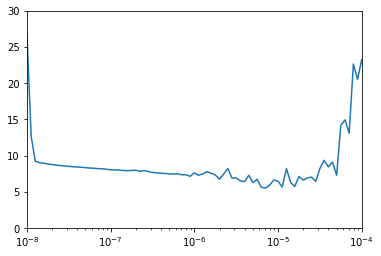

In [9]:
plt.figure()
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [10]:
keras.backend.clear_session()

In [11]:
model = build_model(5e-5)
history = model.fit(dataset, epochs=500, verbose=0)

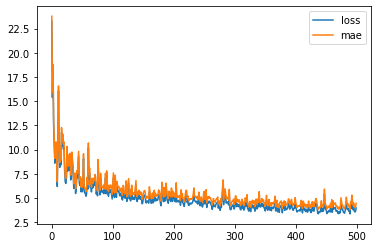

In [12]:
utils.plot_history(history, metrics=[('loss', 'mae')])

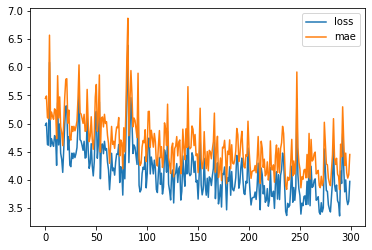

In [13]:
utils.plot_history(history, metrics=[('loss', 'mae')], start=200)

In [14]:
forecasts = []
for t in time_val:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, 0))[0][0]
    forecasts.append(forecast)

In [15]:
utils.evaluate(x_val, forecasts)

mse = 71.0877, mae = 6.2327


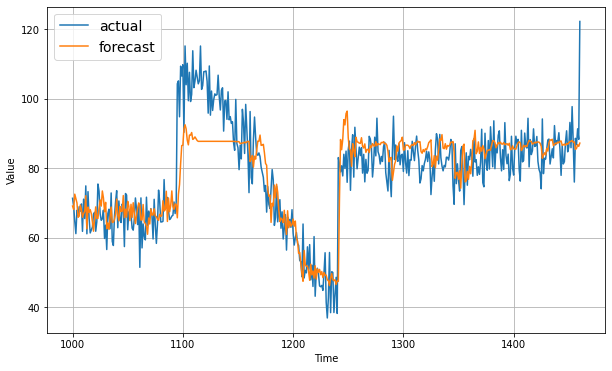

In [16]:
utils.plot_series(time_val, [x_val, forecasts], label=['actual', 'forecast'])